---
title: Acyclic Egraphs and Smart Constructors 
date: 2024-09-16
---

That there are egraph's in the [Cranelift JIT](https://github.com/bytecodealliance/rfcs/blob/main/accepted/cranelift-egraph.md) is a very important proof of concept that a seriously engineered piece of software can use the techniques. It was also really interesting to see the changes that were made.

Right before [Chris Fallin's talk](https://cfallin.org/pubs/egraphs2023_aegraphs_slides.pdf) on the subject, Gilbert and I were musing about how one might go from smart constructors to egraphs.

Max Bernstein ([great blog!!](https://bernsteinbear.com/)) and I have been chatting about egraphs since we met at PLDI. He recently made a post about how he sees this fitting into the framework of a toy optimizing JIT https://bernsteinbear.com/blog/whats-in-an-egraph/ I have some complementary thoughts on this topic that I wanted to share.

Some really interesting discussion was happening here. https://egraphs.zulipchat.com/#narrow/stream/375765-egg.2Fegglog/topic/incrementally.20.22discovering.22.20e-graphs.20from.20union-find/near/468293645

Fallin's summary of the essential points are:

1. A Persistent Union Find using Union Nodes
2. Eager rewriting
3. Acyclicity

You can try this post out here https://colab.research.google.com/github/philzook58/philzook58.github.io/blob/master/pynb/2024-09-16-smart_constructor_aegraph.ipynb


# Persistent Union Find

The union node part of the aegraph can be extracted in just an enumerating union find without the enode complication.

A union find is a forest of equivalence classes. Unlike a typical AST tree representation, the children point up to their parents in this tree. One could call this a converse tree. It is this way so that you can chase the pointers to the canonical root of the equivalence class.

There are 3 styles to union find:
1. Use malloced cells that use pointers to their parents
2. Use a vector arena and indices to represent their parents
3. Use a dictionary data structure to represent the parents

These 3 are really the same thing, but different enough you should be aware.

Between 1 and 3, note that computers ship with a privileged fastest associative map, pointers to memory locations.

Between 2 and 3, you often will bundle the vector arena with a hashcons map if you want to perform unions on anything besides uninterpreted integer identifiers.

A basic union find in the style 2 looks like this:


In [6]:
from dataclasses import dataclass, field
@dataclass
class UF():
    uf : list[int] = field(default_factory=list)
    def makeset(self):
        x = len(self.uf)
        self.uf.append(x)
        return x
    def find(self,x):
        while x != self.uf[x]:
            x = self.uf[x]
        return x
    def union(self,x,y):
        x = self.find(x)
        y = self.find(y)
        self.uf[x] = y
    
uf = UF()
x,y,z = uf.makeset(),uf.makeset(),uf.makeset()
uf.union(x,y)
assert uf.find(x) == uf.find(y)
assert uf.find(x) != uf.find(z)
uf

UF(uf=[1, 1, 2])

In some respects, this is more persistant/immutable than a union find is typically presented. People immediately go for path compression in `find`, but it isn't necessary for functional correctness. The main trick of the proof producing union find is keeping around a copy of the uncompressed tree.

This union find does not maintain the ability to easily enumerate the members of an equivalence class. You can do a full sweep over `uf` and find them. That is what bottom up ematching does. It is very simple. My understanding from the [Z3 version](https://z3prover.github.io/papers/z3internals.html#sec-equality-and-uninterpreted-functions) of this is that you can maintain a doubly linked list of the members of an equivalence class. When `union` merges two equivalence classes, you can splice these two loops together. This version is at the bottom of the post.

But what was done in the acyclic egraph is very interesting.

Instead of making one root asymmetrically point to the other upon `union`, instead `makeset` is called. This creates a new identifier which we can use a mapping to store the (normal directed) tree of children. These new nodes can be called union nodes or unodes.

This tree is some kind of rearrangement of the idea of the above linked list. You can then enumerate out of the eclass by traversing this tree. It is persistent in that you can choose to enumerate out of the eclass as it was at the time of creation, or call find to enumerate as it is now.

In [20]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class UF():
    uf : list[int]
    unodes : list[Optional[tuple[int,int]]]
    def __init__(self):
        self.uf = []
        self.unodes = [] # union_nodes
    def makeset(self):
        z = len(self.uf)
        self.uf.append(z)
        self.unodes.append(None) # or really it might hold an actual thing.
        return z
    def find(self,x):
        while self.uf[x] != x:
            x = self.uf[x]
        return x
    def union(self, x, y):
        x = self.find(x)
        y = self.find(y)
        if x != y:
            z = self.makeset()
            self.uf[x] = z
            self.uf[y] = z
            self.unodes[z] = (x,y)
            return z
        else:
            return x
    def enum(self, x):
        t = self.unodes[x]
        match t:
            case None:
                yield x
            case (l,r):
                yield from self.enum(l)
                yield from self.enum(r)
            case _:
                raise ValueError("Invalid value", x)


uf = UF()
x,y,z = uf.makeset(), uf.makeset(), uf.makeset()
q = uf.union(x,y)
assert list(uf.enum(uf.find(x))) == [x,y]
assert list(uf.enum(x)) == [x]
uf

UF(uf=[3, 3, 2, 3], unodes=[None, None, None, (0, 1)])

# Eager E-matching and Smart Constructors

Another piece that was interesting about the aegraph was that ematching was done at construction time.

This is reminiscent of the approach of rewriting smart constructors.

Very simple dumb constructors for a term represented as tuples might look like this

In [21]:
def const(x : int):
    return ("const",x)
def var(name : str):
    return ("var",name)
def mul(x,y):
    return ("mul", x, y)
def lshift(x,y):
    return ("lshift", x, y)
def div(x,y):
    return ("div", x, y)

two = const(2)
a = var("a")
div(mul(a,two),two)

('div', ('mul', ('var', 'a'), ('const', 2)), ('const', 2))

We can do eager rewriting during construction time with smart constructors. Python pattern matching makes this pretty nice.

In [38]:
def const(x : int):
    return ("const",x)
def var(name : str):
    return ("var", name)
def mul(x,y):
    t = ("mul", x, y)
    match t:
        case ("mul", ("const", x), ("const", y)):
            return const(x * y)
        case ("mul", ("const", 0), b) | ("mul", b, ("const", 0)):
            return ("const", 0)
        case ("mul", ("const", 1), b) | ("mul", b, ("const", 1)):
            return b
        case ("mul", a, ("const", 2)):
            return lshift(a, const(1))
        case _:
            return t
def lshift(x,y):
    t = ("lshift", x, y)
    match t:
        case ("lshift", ("const", 0), b):
            return const(0)
        case ("lshift", a, ("const", 0)):
            return a
        case ("lshift", ("const", x), ("const", y)):
            return ("const", x << y)
        case _ :
            return t
def div(x,y):
    t = ("div", x, y)
    match t:
        case ("div", ("mul", a, b), b1) if b == b1 and b != const(0):
            return a
        case _:
            return t

two = const(2)
a = var("a")

assert mul(const(2),const(3)) == const(6)
div(mul(a,two),two)

('div', ('lshift', ('var', 'a'), ('const', 1)), ('const', 2))

## Multiterms

Note we have missed out on an optimization by being too eager in our rewriting. The multiplication turned into a bit shift before the divide could do a more useful rewrite.

What we have is a nonconfluent but terminating rewrite system.

We can instead construct multiterms, outputting all the possible rewrites. This is one way of fixing nonconfluence. We need to do some search. We can then extract the best term out of our options.



In [156]:
def const(x : int):
    return [("const",x)]
def var(name : str):
    return [("var", name)]
def mul(xs,ys):
    for x in xs:
        for y in ys:
            t = ("mul", x, y)
            yield t
            match t:
                case ("mul", ("const", x), ("const", y)):
                    yield ("const", x * y)
            match t:
                case ("mul", ("const", 0), b) | ("mul", b, ("const", 0)):
                    yield ("const", 0)
            match t:
                case ("mul", ("const", 1), b) | ("mul", b, ("const", 1)):
                    yield b
            match t:
                case ("mul", a, ("const", 2)):
                    yield ("lshift", a, ("const", 1))

def lshift(xs,ys):
    for x in xs:
        for y in ys:
            t = ("lshift", x, y)
            yield t
            match t:
                case ("lshift", ("const", 0), b):
                    yield ("const", 0)
            match t:
                case ("lshift", a, ("const", 0)):
                    yield a
            match t:
                case ("lshift", ("const", x), ("const", y)):
                    yield ("const", x << y)

def div(xs,ys):
    for x in xs:
        for y in ys:
            t = ("div", x, y)
            yield t
            match t:
                case ("div", ("mul", a, b), b1) if b == b1 and b != const(0):
                    yield a
                case _:
                    yield t

two = const(2)
a = var("a")

print(list(div(mul(a,two), two)))
def size(t):
    if not isinstance(t, tuple):
        return 1
    return 1 + sum(map(size, t[1:]))
def extract(ts):
    return min(ts, key=size)
extract(div(mul(a,two),two))


[('div', ('mul', ('var', 'a'), ('const', 2)), ('const', 2)), ('var', 'a'), ('div', ('lshift', ('var', 'a'), ('const', 1)), ('const', 2)), ('div', ('lshift', ('var', 'a'), ('const', 1)), ('const', 2))]


('var', 'a')

You know, brute force is kind of nice. We don't give it a shot nearly enough.

Eagerly expanding out the terms ion the constructors is expensive. The only reason we need to do this is because we need to search to apply our rewrite patterns.

The egraph can be thought of as a way to keep the shared structure compacted or unexpanded.

[Version Space Algebras](https://remy.wang/reports/dfta.pdf) are a relative of egraphs that have the flavor of unexpanded multiterms

# Putting it together into the AEGraph

So we can mix together these two ideas into an AEGraph data structure.

I keep the `enodes` and `unodes` lists separate because I feel they have separate concerns. But they are intimately related. Exactly one of them should be a `None`.

As a simple, but monstrously indulgent way of implementing ematching, I have the generator `term_view`, which will partially expand out all terms from an eid in the egraph. One wold want to instead implement a pattern language, compile to abstract machine, or do codegen to search for your patterns.


In [157]:
from dataclasses import dataclass
from typing import Optional, NewType, Iterable
import itertools
import networkx as nx
EId = NewType("EId", int)

@dataclass(frozen=True)
class ELit:
    value: object

@dataclass(frozen=True)
class Enode:
    name:str
    args:tuple[EId, ...]



@dataclass
class AEGraph():
    uf : list[EId] = field(default_factory=list)
    unodes : list[Optional[tuple[EId,EId]]] = field(default_factory=list)
    enodes : list[Optional[Enode | ELit]] = field(default_factory=list)
    hashcons : dict[Enode | ELit, EId] = field(default_factory=dict)
    def makeset(self) -> EId:
        z = len(self.uf)
        self.uf.append(z)
        self.unodes.append(None) # or really it might hold an actual thing.
        self.enodes.append(None)
        return EId(z)
    def find(self,x: EId) -> EId:
        while self.uf[x] != x:
            x = self.uf[x]
        return x
    def union(self, x : EId, y : EId) -> EId:
        assert isinstance(x, int) and isinstance(y, int)
        x = self.find(x)
        y = self.find(y)
        if x != y:
            z = self.makeset()
            self.uf[x] = z
            self.uf[y] = z
            self.unodes[z] = (x,y)
            return z
        else:
            return x
    def enum(self, x : EId) -> Iterable[EId]:
        t = self.unodes[x]
        match t:
            case None:
                yield x
            case (l,r):
                yield from self.enum(l)
                yield from self.enum(r)
            case _:
                raise ValueError("Invalid value", x)
    def add_enode(self, enode : (Enode | ELit)) -> EId:
        # should I call find on the enode args here?
        eid = self.hashcons.get(enode)
        if eid is not None:
            return eid
        eid = self.makeset()
        self.enodes[eid] = enode
        self.hashcons[enode] = eid
        return eid
    def add_term(self, term) -> EId:
        if isinstance(term, tuple):
            if term[0] == "$eid":
                return term[1]
            else:
                name, *args = term
                args = tuple(self.add_term(arg) for arg in args)
                return self.add_enode(Enode(name, args))
        else:
            return self.add_enode(ELit(term))
    def term_view(self, eid : EId, depth : int):
        assert depth >= 0
        if depth == 0: # don't expand and leave it as special unexpanded term
            yield ("$eid", eid) 
        else:
            for eid1 in self.enum(eid):
                enode = self.enodes[eid1]
                if isinstance(enode, ELit):
                    yield enode.value
                elif isinstance(enode, Enode):
                    for args in itertools.product(*[self.term_view(arg, depth-1) for arg in enode.args]):
                        yield (enode.name, *args)

    # theory specific smart constructors
    def const(self, x : int) -> EId:
        eid = self.add_term(("const", x))
        return eid
    def var(self, name : str) -> EId:
        eid = self.add_term(("var", name))
        return eid
    def mul(self, x : EId, y : EId) -> EId:
        eid = self.add_enode(Enode("mul", (x,y)))
        for t in self.term_view(eid, 3):
            match t:
                case ("mul", ("const", x), ("const", y)):
                    self.union(self.const(x*y), eid)
            match t:
                case ("mul", ("const", 0), b) | ("mul", b, ("const", 0)):
                    self.union(self.const(0), eid)
            match t:
                case ("mul", ("const", 1), b) | ("mul", b, ("const", 1)):
                    self.union(self.add_term(b), eid)
            match t:
                case ("mul", a, ("const", 2)):
                    self.union(self.lshift(self.add_term(a), self.const(1)), eid)
        return self.find(eid)
    def lshift(self, x : EId, y : EId) -> EId:
        eid = self.add_enode(Enode("lshift", (x,y)))
        for t in self.term_view(eid, 3):
            match t:
                case ("lshift", ("const", 0), b):
                    self.union(self.const(0), eid)
            match t:
                case ("lshift", a, ("const", 0)):
                    self.union(self.add_term(a), eid)
            match t:
                case ("lshift", ("const", x), ("const", y)):
                    self.union(self.const(x << y), eid)
        return self.find(eid)
    def div(self, x : EId, y : EId) -> EId:
        eid = self.add_enode(Enode("div", (x,y)))
        for t in self.term_view(eid, 4):
            match t:
                case ("div", ("mul", a, b), b1) if b == b1 and b != 0:
                    self.union(self.add_term(a), eid)
        return self.find(eid)
    
    
E = EGraph()
one = E.const(1)
two = E.const(2)
E
a = E.var("a")
E.union(a,one)
assert a == E.add_term(("var", "a"))
assert one == E.add_term(("const", 1))
print(E)
mulaone = E.mul(a,one)
print(mulaone)
print(E)
E.find(E.add_term(("mul", ("$eid", a), ("$eid", one))))  == mulaone
E.mul(one,one)
E.check()
divnode = E.div(E.mul(a,two), two)
assert E.find(divnode) == E.find(a)

EGraph(uf=[0, 6, 2, 3, 4, 6, 6], unodes=[None, None, None, None, None, None, (5, 1)], enodes=[ELit(value=1), Enode(name='const', args=(0,)), ELit(value=2), Enode(name='const', args=(2,)), ELit(value='a'), Enode(name='var', args=(4,)), None], hashcons={ELit(value=1): 0, Enode(name='const', args=(0,)): 1, ELit(value=2): 2, Enode(name='const', args=(2,)): 3, ELit(value='a'): 4, Enode(name='var', args=(4,)): 5})
8
EGraph(uf=[0, 6, 2, 3, 4, 6, 8, 8, 8], unodes=[None, None, None, None, None, None, (5, 1), None, (6, 7)], enodes=[ELit(value=1), Enode(name='const', args=(0,)), ELit(value=2), Enode(name='const', args=(2,)), ELit(value='a'), Enode(name='var', args=(4,)), None, Enode(name='mul', args=(5, 1)), None], hashcons={ELit(value=1): 0, Enode(name='const', args=(0,)): 1, ELit(value=2): 2, Enode(name='const', args=(2,)): 3, ELit(value='a'): 4, Enode(name='var', args=(4,)): 5, Enode(name='mul', args=(5, 1)): 7})


# Bits and Bobbles
I think by reiterating over the egraph and reinserting what you find, you can achieve the same effect as equality saturation. So I don't think the acyclicity is a stopper from doing regular egraph stuff.

I'm not really sure what the acyclicty means.

There is some design choice on where you want to insert `find` operations, call smart constructors vs dumb constructors, maybe early stop search. Wrong choices may be non terminating.



Top down ematching is a relative of extraction. You locally do a small extraction enumerating all the term heads.

- https://egraphs.zulipchat.com/#narrow/stream/375765-egg.2Fegglog/topic/incrementally.20.22discovering.22.20e-graphs.20from.20union-find/near/467682535

- https://github.com/bytecodealliance/wasmtime/blob/main/cranelift/codegen/src/egraph.rs
- https://github.com/bytecodealliance/wasmtime/blob/main/cranelift/codegen/src/egraph/elaborate.rs
- https://github.com/bytecodealliance/wasmtime/blob/main/cranelift/codegen/src/egraph/cost.rs
- https://github.com/bytecodealliance/wasmtime/blob/main/cranelift/codegen/src/opts.rs




Another thing we can do with smart constructors is hashcons / intern them.
This gives us a fast syntactic equality check



The doubly linked list egraph is a different method of enumeration

Maybe a singly linked list is sufficient, but this might also be interesting from a dancing links style backtracking perspective.

Actually do we even need find? Is there benefit to different splicing options?

In [ ]:
from dataclasses import dataclass, field
@dataclass
class UF():
    uf : list[int] = field(default_factory=list)
    left : list[int] = field(default_factory=list)
    right : list[int] = field(default_factory=list)
    def makeset(self):
        x = len(self.uf)
        self.uf.append(x)
        self.left.append(x)
        self.right.append(x)
        return x
    def find(self,x):
        while x != self.uf[x]:
            x = self.uf[x]
        return x
    def union(self,x,y):
        x = self.find(x)
        y = self.find(y)
        if x != y:
            self.uf[x] = y
            right_x = self.right[x]
            left_y = self.left[y]

            self.right[x] = y
            self.left[y] = x

            self.right[left_y] = right_x
            self.left[right_x] = left_y 
    def enum(self, x0):
        x = self.right[x0]
        yield x0
        while x != x0:
            yield x
            x = self.right[x]

    
uf = UF()
x,y,z = uf.makeset(),uf.makeset(),uf.makeset()
uf.union(x,y)
assert uf.find(x) == uf.find(y)
assert uf.find(x) != uf.find(z)
assert list(uf.enum(x)) == [0,1]
uf.union(y,z)
assert list(uf.enum(x)) == [0,1,2]

Some code to convert the aegraph to a networkx graph. It looked like gabrage though

In [ ]:
    def graph(self):
        G = nx.DiGraph()
        for eid, enode in enumerate(self.enodes):
            if enode is not None:
                if isinstance(enode, ELit):
                    G.add_node(eid, label=enode.value)
                else:
                    G.add_node(eid, label=enode.name)
                    for arg in enode.args:
                        G.add_edge(eid, arg)
        for eid, unode in enumerate(self.unodes):
            if unode is not None:
                G.add_node(eid, color="red")
                G.add_edge(eid, unode[0])
                G.add_edge(eid, unode[1])
        return G
    def draw_graph(self):
        G = self.graph()
        pos = nx.spring_layout(G)
        labels = nx.get_node_attributes(G, 'label')
        colors = ['red' if G.nodes[n].get('color') == 'red' else 'white' for n in G.nodes()]
        nx.draw(G, pos, labels=labels, node_color=colors, with_labels=True)
        plt.show()


def check(self):
    # sanity check properties
    for enode, unode in zip(self.enodes, self.unodes):
        assert (unode is None) != (enode is None)
    for eid, unode in enumerate(self.unodes):
        assert unode is None or isinstance(unode, tuple) 
    for eid, enode in enumerate(self.enodes):
        if enode is not None:
            assert isinstance(enode, Enode | ELit)
            assert self.hashcons[enode] == eid

In [ ]:
    def extract(self, eid):
        pass
        """
        If i iterate over uf 
        cost = [float("int")] * len(self.uf)
        for eid in range(len(self.uf)):
            for eid1 in self.enum(eid):
                self.enodes[eid1]
                sum(cost[arg] for arg in enode.args)
                cost[]
            cost[eid] = size(self.enodes[eid])
        """





https://www.philipzucker.com/bottom_up/
I mentioned that it reminded me of aegraphs.
Jamie responded on mastodon

aegraph slides


Hashconsing.
You don't want to hash recursively anymore. So we need to override


Top down matching puts each pattern into its head smart constructor
A bottom up style puts each piece into a different smart constructor. Which is a bummer.



https://www.pypy.org/posts/2022/10/toy-optimizer-allocation-removal.html
JIT is straight line which is pretty cool.

JIT guards are like asserts. They have a notion of context that we learn things that are true past them

cleaning up allocations is important. Analsysi to avoid calling new or onlycall new after its settled down
Assume type data objects haven't changed.

https://github.com/tekknolagi/zero-to-aegraphs/tree/trunk

https://www.pypy.org/posts/2022/07/toy-optimizer.html

Version Space Algebras

In [2]:
# multiterms



def add(x,y):
    return [("add", x,y)]

def div(x,y):
    return [("div", x,y)]

def mul(x,y):
    return [("mul", x,y)]

def lit(x):
    return [("lit", x)]

def lshift(x,y):
    return [("lshift", x,y)]

# obviously the pattern can be abstracted as
def multiterm(sym):
    def res(*args):
        return [(sym, *args)]
    return res



In [ ]:
def mul(x,y):
    res = [("mul", x,y)]
    if lit(1) in x:
        res.append(y)
    if lit(1) in y:
        res.append(x)
    if lit(2) in y:
        res.extend(lshift(x,lit(1)))
    return res

def div(x,y):
    pass

In [ ]:
# aegraph






In [1]:
import dataclasses
from typing import Optional, Tuple


class Value:
    def find(self):
        raise NotImplementedError("abstract")

    def _set_forwarded(self, value):
        raise NotImplementedError("abstract")


@dataclasses.dataclass(eq=True, unsafe_hash=True)
class Constant(Value):
    value: object

    def find(self):
        return self

    def _set_forwarded(self, value: Value):
        assert isinstance(value, Constant) and value.value == self.value


@dataclasses.dataclass(eq=True, unsafe_hash=True)
class Operation(Value):
    name: str
    args: tuple[Value]
    forwarded: Optional[Value] = dataclasses.field(default=None, hash=False)

    __match_args__ = ("name", "args")

    def find(self) -> Value:
        op = self
        while isinstance(op, Operation):
            next = op.forwarded
            if next is None:
                return op
            op = next
        return op

    def arg(self, index):
        return self.args[index].find()

    def make_equal_to(self, value: Value):
        self.find()._set_forwarded(value)

    def _set_forwarded(self, value: Value):
        self.forwarded = value


@dataclasses.dataclass
class EGraph(list):
    seen: dict[Tuple[str, Tuple[Value, ...]], Value] = dataclasses.field(
        default_factory=dict
    )

    def _emit(self, op):
        key = (op.name, op.args)
        if key in self.seen:
            return self.seen[key]
        self.seen[key] = op
        self.append(op)
        return op

    def add(self, left, right):
        match (left, right):
            case (Constant(a), Constant(0)):
                return left
            case _:
                return self._emit(Operation("add", (left, right)))

    def mul(self, left, right):
        match (left, right):
            # case (_, Constant(2)):
            #     return Operation("lshift", [left, Constant(1)])
            case _:
                return self._emit(Operation("mul", (left, right)))

    def div(self, left, right):
        match (left, right):
            # case (_, Constant(2)):
            #     return Operation("rshift", [left, Constant(1)])
            case (Operation("mul", (a, b0)), b1) if b0 == b1:
                return a
            case _:
                return self._emit(Operation("div", (left, right)))


def bb_to_str(bb: EGraph, varprefix: str = "var"):
    def arg_to_str(arg: Value):
        if isinstance(arg, Constant):
            return str(arg.value)
        else:
            return varnames[arg]

    varnames = {}
    res = []
    for index, op in enumerate(bb):
        if isinstance(op, Constant):
            continue
        var = f"{varprefix}{index}"
        varnames[op] = var
        arguments = ", ".join(arg_to_str(op.arg(i)) for i in range(len(op.args)))
        strop = f"{var} = {op.name}({arguments})"
        res.append(strop)
    return "\n".join(res)


a = Constant(42)
bb = EGraph()
b = bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
bb.mul(a, Constant(2))
c = bb.div(b, Constant(2))
print(bb_to_str(bb))
print(c)

var0 = mul(42, 2)
Constant(value=42)


In [26]:
table = {}
def hashcons(c):
    c1 = table.get(c)
    if c1 == None:
        table[c] = c 
        return c
    else:
        return c1
# simple hash consing. Not type safe. Has non short circuiting equality.
# still maybe it's good enough


a = hashcons((1,2,3))
b = hashcons((1,2,3))
c = (1,2,3)
assert not c is b
assert a is b

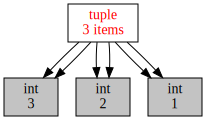

In [30]:
import objgraph
objgraph.show_refs((a,b))

In [38]:
table = {} # hashable -> Intern(hashable)
def hashcons(c):
    c1 = table.get(c)
    if c1 == None:
        c1 = Intern(c)
        table[c] = c1 
        return c1
    else:
        return c1
    
from dataclasses import dataclass
@dataclass(frozen=True, slots=True)
class Intern():
    data: "Any"
    def __hash__(self):
        print("hashing", self)
        return hash(id(self))
    def __eq__(self, other):
        print("==?", self, other)
        return self is other

a = hashcons((1,2,3))
b = hashcons((1,2,3))
a == b
table

x = hashcons(())
print("y")
y = hashcons((x,x))
print("z")
z = hashcons((y,))
z1 = hashcons((y,))
assert z1 is z
w = hashcons((z,z,z))

==? Intern(data=(1, 2, 3)) None
==? Intern(data=(1, 2, 3)) Intern(data=(1, 2, 3))
y
hashing Intern(data=())
hashing Intern(data=())
hashing Intern(data=())
hashing Intern(data=())
z
hashing Intern(data=(Intern(data=()), Intern(data=())))
hashing Intern(data=(Intern(data=()), Intern(data=())))
hashing Intern(data=(Intern(data=()), Intern(data=())))
==? Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),)) None
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))
hashing Intern(data=(Intern(data=(Intern(data=()), Intern(data=()))),))


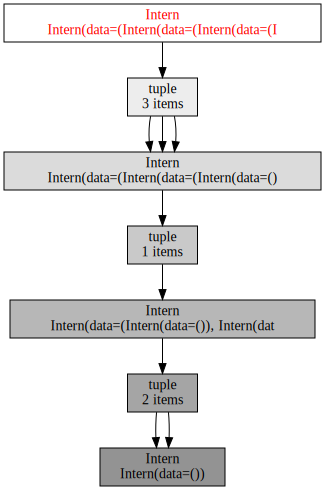

In [39]:
# https://mg.pov.lt/objgraph/ visualizer of object graph
import objgraph
objgraph.show_refs([w], max_depth=10, filter = lambda x: not isinstance(x,type))

Smart constructors

I can have add auto recognize 0, const prop, and associativity commutativity.

We're pretty used to the behavior in the context of representing polynomials. Sympy is rotten with this kind of thing, which can be a problem for some use cases.

This is showing just basic 

In [ ]:
# ok so consider if smart cosnturctor outputs a set/list of interned nodes instead of 

def mul(x,y):
    out = [("mul", x, y)]
    if y == 2:
        out.append(("<<", x, 1))
    return out

# Can I do ematcjing with respect to a previous 

# now matching through finds the indirections
def div(x,y):
    out = [("div", x, y)]
    for x in xs:
        match x:
            case ("mul", a, n):
                for y in ys:
                    match y:
                        case n:
                            out.append(x)
# oh yea. I forgot when you top down ematch it's pretty simple too for concrete problems.


# so where does the union find come in?
# Well, we may discover new versions coming from above.
# Seems marginal though.

# But if I don't, we don't learn anything?




In [5]:
def add(x,y):
    if x == 0:
        return y
    elif y == 0:
        return x
    elif isinstance(x,int) and isinstance(y,int): # const prop
        return x + y
    match y:
        case ("add", ybits):
            ys = ybits
        case _:
            ys = [y]
    match x:
        case ("add", xbits):
            xs = xbits
        case _:
            xs = [x]
    return ("add",sorted(xs + ys))   # hashcons 

add(1,add(2,"x"))



TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:



options = {}
partials = {}

def hashcons(con):
    match con:
        case ("add", a, b):
            if a == 0:
                return b
            else 
        case ("mul", a, b):
    
    return options, partials





def explain(uf, x, y):
    pass









cascades

aegraph
tree of unions

But later things can tap into the frozenset. hmm.
so maybe nested frozensets

smart construcotrs - hashcons frozenset

25-30 minutes. yowzers

Use z3 external egraph. Bottom up, aegraph or grs style.


```python

def add(x,y):
    match x:
        Add()


```